# Research Workflow

This notebook demonstrates the research [workflow](https://langchain-ai.github.io/langgraph/tutorials/workflows/) that creates comprehensive reports through a series of focused steps. The system:

1. Uses a **graph workflow** with specialized nodes for each report creation stage
2. Enables user **feedback and approval** at critical planning points 
3. Produces a well-structured report with introduction, researched body sections, and conclusion

## From repo 

In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

c:\Users\62687\Desktop\个人\实习相关\标准化研究院实习\open_deep_research\src


## From package 

In [15]:
! pip install -U -q open-deep-research


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


# Compile the Graph-Based Research Workflow

The next step is to compile the LangGraph workflow that orchestrates the report creation process. This defines the sequence of operations and decision points in the research pipeline.

In [2]:
# Import required modules and initialize the builder from open_deep_research
import uuid 
import os, getpass
import open_deep_research   
print(open_deep_research.__version__) 
from IPython.display import Image, display, Markdown
from langgraph.types import Command
from langgraph.checkpoint.memory import MemorySaver
from open_deep_research.graph import builder

0.0.15


In [3]:
# Create a memory-based checkpointer and compile the graph
# This enables state persistence and tracking throughout the workflow execution

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

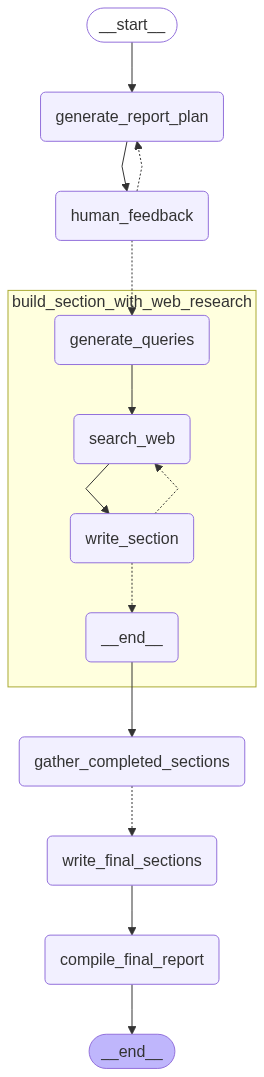

In [4]:
# Visualize the graph structure
# This shows the nodes and edges in the research workflow

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# Helper function to set environment variables for API keys
# This ensures all necessary credentials are available for various services

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# Set the API keys used for any model or search tool selections below, such as:
_set_env("OPENAI_API_KEY")
_set_env("ANTHROPIC_API_KEY")
_set_env("TAVILY_API_KEY")
_set_env("GROQ_API_KEY")
_set_env("PERPLEXITY_API_KEY")

In [ ]:
# Define report structure template and configure the research workflow
# This sets parameters for models, search tools, and report organization

REPORT_STRUCTURE = """Use this structure to create a report on the user-provided topic:

1. Introduction (no research needed)
   - Brief overview of the topic area

2. Main Body Sections:
   - Each section should focus on a sub-topic of the user-provided topic
   
3. Conclusion
   - Aim for 1 structural element (either a list of table) that distills the main body sections 
   - Provide a concise summary of the report"""

# Configuration option 1: Claude 3.7 Sonnet for planning with perplexity search
thread = {"configurable": {"thread_id": str(uuid.uuid4()),
                           "search_api": "perplexity",
                           "planner_provider": "anthropic",
                           "planner_model": "claude-3-7-sonnet-latest",
                           # "planner_model_kwargs": {"temperature":0.8}, # if set custom parameters
                           "writer_provider": "anthropic",
                           "writer_model": "claude-3-5-sonnet-latest",
                           # "writer_model_kwargs": {"temperature":0.8}, # if set custom parameters
                           "max_search_depth": 2,
                           "report_structure": REPORT_STRUCTURE,
                           }}

# Configuration option 2: DeepSeek-R1-Distill-Llama-70B for planning and llama-3.3-70b-versatile for writing
thread = {"configurable": {"thread_id": str(uuid.uuid4()),
                           "search_api": "tavily",
                           "planner_provider": "groq",
                           "planner_model": "deepseek-r1-distill-llama-70b",
                           "writer_provider": "groq",
                           "writer_model": "llama-3.3-70b-versatile",
                           "report_structure": REPORT_STRUCTURE,
                           "max_search_depth": 1,}
                           }

# Configuration option 3: Use OpenAI o3 for both planning and writing (selected option)
thread = {"configurable": {"thread_id": str(uuid.uuid4()),
                           "search_api": "tavily",
                           "planner_provider": "openai",
                           "planner_model": "o3",
                           "writer_provider": "openai",
                           "writer_model": "o3",
                           "max_search_depth": 2,
                           "report_structure": REPORT_STRUCTURE,
                           }}

# Define research topic about Model Context Protocol
topic = "Overview of Model Context Protocol (MCP), an Anthropic‑backed open standard for integrating external context and tools with LLMs. Give an architectural overview for developers, tell me about interesting MCP servers, and compare to google Agent2Agent (A2A) protocol."

# Run the graph workflow until first interruption (waiting for user feedback)
async for event in graph.astream({"topic":topic,}, thread, stream_mode="updates"):
    if '__interrupt__' in event:
        interrupt_value = event['__interrupt__'][0].value
        display(Markdown(interrupt_value))

# User Feedback Phase

* This allows for providing directed feedback on the initial report plan
* The user can review the proposed report structure and provide specific guidance
* The system will incorporate this feedback into the final report plan

In [ ]:
# Submit feedback on the report plan
# The system will continue execution with the updated requirements

# Provide specific feedback to focus and refine the report structure
async for event in graph.astream(Command(resume="Looks great! Just do one section related to Agent2Agent (A2A) protocol, introducing it and comparing to MCP."), thread, stream_mode="updates"):
    if '__interrupt__' in event:
        interrupt_value = event['__interrupt__'][0].value
        display(Markdown(interrupt_value))

# Final Approval Phase
* After incorporating feedback, approve the plan to start content generation

In [ ]:
# Approve the final plan and execute the report generation
# This triggers the research and writing phases for all sections

# The system will now:
# 1. Research each section topic
# 2. Generate content with citations
# 3. Create introduction and conclusion
# 4. Compile the final report

async for event in graph.astream(Command(resume=True), thread, stream_mode="updates"):
    print(event)
    print("\n")

In [9]:
# Display the final generated report
# Retrieve the completed report from the graph's state and format it for display

final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Introduction  
Large language models excel at reasoning, but without structured access to the outside world they remain isolated. The Model Context Protocol (MCP) bridges this gap, defining an open, vendor‑neutral way for models to tap files, databases, APIs, and other tools through simple JSON‑RPC exchanges. This report walks developers through the protocol’s architecture, surveys real‑world MCP servers that showcase its flexibility, and contrasts MCP with Google’s emerging Agent‑to‑Agent (A2A) standard. By the end, you should know when, why, and how to weave MCP into your own agentic systems.

## MCP Architectural Overview for Developers

MCP uses a client‑host‑server model: a host process spawns isolated clients, and every client keeps a 1‑to‑1, stateful session with a single server that exposes prompts, resources, and tools through JSON‑RPC 2.0 messages [1][5].  

A session passes through three phases — initialize, operation, shutdown. The client begins with an initialize request that lists its protocolVersion and capabilities; the server replies with a compatible version and its own capabilities. After the client’s initialized notification, both sides may exchange requests, responses, or one‑way notifications under the agreed capabilities [2].  

Two official transports exist. Stdio is ideal for local child processes, while HTTP (SSE/“streamable HTTP”) supports multi‑client, remote scenarios. Both must preserve JSON‑RPC framing, and servers should validate Origin headers, bind to localhost where possible, and apply TLS or authentication to block DNS‑rebind or similar attacks [1][3].  

To integrate MCP, developers can:  
1) implement a server that registers needed primitives and advertises them in initialize.result.capabilities;  
2) validate all inputs and set reasonable timeouts;  
3) or consume existing servers via SDKs—select a transport, send initialize, then invoke or subscribe to tools/resources exactly as negotiated [4][5].  

### Sources  
[1] MCP Protocol Specification: https://www.claudemcp.com/specification  
[2] Lifecycle – Model Context Protocol: https://modelcontextprotocol.info/specification/draft/basic/lifecycle/  
[3] Transports – Model Context Protocol: https://modelcontextprotocol.io/specification/2025-03-26/basic/transports  
[4] Core Architecture – Model Context Protocol: https://modelcontextprotocol.io/docs/concepts/architecture  
[5] Architecture – Model Context Protocol Specification: https://spec.modelcontextprotocol.io/specification/2025-03-26/architecture/

## Ecosystem Spotlight: Notable MCP Servers

Hundreds of MCP servers now exist, spanning core data access, commercial platforms, and hobby projects—proof that the protocol can wrap almost any tool or API [1][2].

Reference servers maintained by Anthropic demonstrate the basics.  Filesystem, PostgreSQL, Git, and Slack servers cover file I/O, SQL queries, repository ops, and chat workflows.  Developers can launch them in seconds with commands like  
`npx -y @modelcontextprotocol/server-filesystem` (TypeScript) or `uvx mcp-server-git` (Python) and then point any MCP‑aware client, such as Claude Desktop, at the spawned process [1].

Platform vendors are adding “first‑party” connectors.  Microsoft cites the GitHub MCP Server and a Playwright browser‑automation server as popular examples that let C# or .NET apps drive code reviews or end‑to‑end tests through a uniform interface [3].  Other partner servers—e.g., Cloudflare for edge resources or Stripe for payments—expose full product APIs while still enforcing user approval through MCP’s tool‑calling flow [2].

Community builders rapidly fill remaining gaps.  Docker and Kubernetes servers give agents controlled shell access; Snowflake, Neon, and Qdrant handle cloud databases; Todoist and Obsidian servers tackle personal productivity.  Because every server follows the same JSON‑RPC schema and ships as a small CLI, developers can fork an existing TypeScript or Python implementation and swap in their own SDK calls to create new connectors in hours, not weeks [2].  

### Sources  
[1] Example Servers – Model Context Protocol: https://modelcontextprotocol.io/examples  
[2] Model Context Protocol Servers Repository: https://github.com/madhukarkumar/anthropic-mcp-servers  
[3] Microsoft partners with Anthropic to create official C# SDK for Model Context Protocol: https://devblogs.microsoft.com/blog/microsoft-partners-with-anthropic-to-create-official-c-sdk-for-model-context-protocol

## Agent‑to‑Agent (A2A) Protocol and Comparison with MCP  

Google’s Agent‑to‑Agent (A2A) protocol, announced in April 2025, gives autonomous agents a common way to talk directly across vendors and clouds [2]. Its goal is to let one “client” agent delegate work to a “remote” agent without sharing internal code or memory, enabling true multi‑agent systems.  

Discovery starts with a JSON Agent Card served at /.well‑known/agent.json, which lists version, skills and endpoints [3]. After discovery, the client opens a Task—an atomic unit that moves through states and exchanges Messages and multimodal Artifacts. HTTP request/response, Server‑Sent Events, or push notifications are chosen based on task length to stream progress safely [2].  

Anthropic’s Model Context Protocol (MCP) tackles a different layer: it links a single language model to external tools and data through a Host‑Client‑Server triad, exposing Resources, Tools and Prompts over JSON‑RPC [1]. Communication is model‑to‑tool, not agent‑to‑agent.  

Google therefore calls A2A “complementary” to MCP: use MCP to give each agent the data and actions it needs; use A2A to let those empowered agents discover one another, coordinate plans and exchange results [1]. In practice, developers might pipe an A2A task that, mid‑flow, invokes an MCP tool or serve an MCP connector as an A2A remote agent, showing the standards can interlock instead of compete.  

### Sources  
[1] MCP vs A2A: Comprehensive Comparison of AI Agent Protocols: https://www.toolworthy.ai/blog/mcp-vs-a2a-protocol-comparison  
[2] Google A2A vs MCP: The New Protocol Standard Developers Need to Know: https://www.trickle.so/blog/google-a2a-vs-mcp  
[3] A2A vs MCP: Comparing AI Standards for Agent Interoperability: https://www.ikangai.com/a2a-vs-mcp-ai-standards/

## Conclusion

Model Context Protocol (MCP) secures a model’s immediate tool belt, while Google’s Agent‑to‑Agent (A2A) protocol enables those empowered agents to find and hire one another. Their scopes differ but interlock, giving developers a layered recipe for robust, multi‑agent applications.

| Aspect | MCP | A2A |
| --- | --- | --- |
| Layer | Model‑to‑tool RPC | Agent‑to‑agent orchestration |
| Session start | `initialize` handshake | Task creation lifecycle |
| Discovery | Client‑supplied server URI | `/.well‑known/agent.json` card |
| Streaming | Stdio or HTTP/SSE | HTTP, SSE, or push |
| Best fit | Embed filesystems, DBs, SaaS APIs into one agent | Delegate subtasks across clouds or vendors |

Next steps: prototype an A2A task that internally calls an MCP PostgreSQL server; harden both layers with TLS and capability scoping; finally, contribute a new open‑source MCP connector to accelerate community adoption.

Trace: 

> Note: uses 80k tokens 

https://smith.langchain.com/public/31eca7c9-beae-42a3-bef4-5bce9488d7be/r